**Note:** Visualization is created for the single simulation.

In [1]:
import time
import os
import shutil
from collections import namedtuple
import numpy as np
import scipy as sp
from scipy import optimize
import h5py
import pickle
import matplotlib.pyplot as plt

In [2]:
root_dir = './results/'
img_dir = os.path.join(root_dir, 'frames/')
if os.path.exists(img_dir):
    shutil.rmtree(img_dir)
os.makedirs(img_dir)

d = pickle.load(open(root_dir + 'c.p', 'rb'))
c = namedtuple('Const', d.keys())(**d)

h5f = h5py.File(root_dir + 'results.hdf5', 'r')
Z_history = h5f['Results'][:]
h5f.close()

In [3]:
# Create all frames
start = time.time()
fig, ax = plt.subplots(1, figsize=(12, 12))

for i in range(c.n_iterations):
    
    ax.imshow(Z_history[:, :, i], cmap='bone', interpolation=None)
    
    ax.set_title('Frame:' + str(i))
    ax.axis('off')
    
    fig.savefig(img_dir + 'img_{0:05d}'.format(i))
    
    ax.cla()
    
plt.close(fig)
print('Time elapsed: ', time.time() - start)

Time elapsed:  207.26531410217285


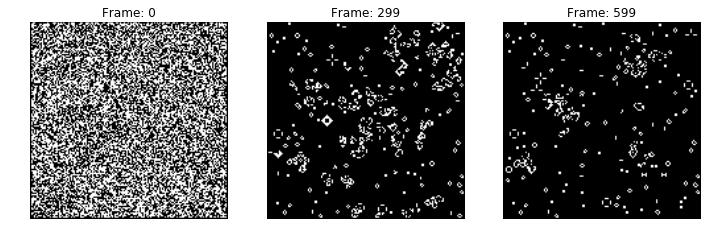

In [4]:
# Sample frames from the simulation
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for k, ax in enumerate(axes):
    frame_idx = int((k/2.) * (c.n_iterations - 1))
    ax.imshow(Z_history[:, :, frame_idx], cmap='bone', interpolation=None)
    
    ax.set_title('Frame: ' + str(frame_idx))
    ax.axis('off')

plt.show()
plt.close(fig)

In [5]:
# Create video
cmd = 'ffmpeg -framerate 10 -i ./results/frames/img_%05d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ./results/output.mp4'
os.system(cmd)

0

In [6]:
# Find an exponential fit for Population vs. Time
pop = []
for i in range(c.n_iterations):
    pop.append(Z_history[:, :, i].sum())

def func(x, a, b, d):
    return a * np.exp(-b * x) + d

# Fit the first part to exponential decay
x1pts = np.array(range(5, 100))
(a, b, d), pcov = optimize.curve_fit(func, x1pts, pop[5:100])
y1pts = func(x1pts, a, b, d)

# Fit the second part to linear decay
x2pts = np.array(range(100, c.n_iterations))
z = np.polyfit(x2pts, pop[100:], 1)
p = np.poly1d(z)
y2pts = p(x2pts)

/home/metta/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in exp


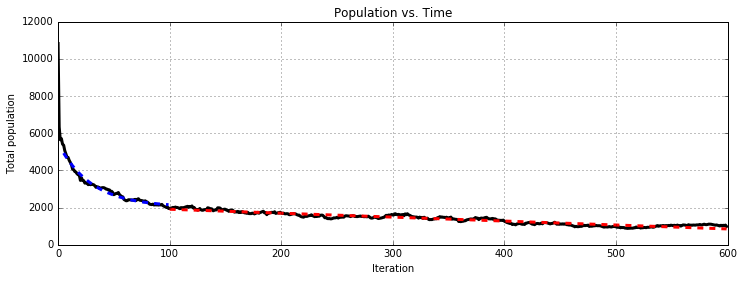

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(pop, lw=3, color='k')
ax.plot(x1pts, y1pts, color='b', ls='--', lw=3)
ax.plot(x2pts, y2pts, color='r', ls='--', lw=3)

ax.set_title('Population vs. Time')
ax.set_xlabel('Iteration')
ax.set_ylabel('Total population')
ax.grid()

plt.show()
plt.close(fig)

**Comments:** We have an initial exponential decay followed by linear decay.